[*********************100%%**********************]  1 of 1 completed


Final Capital: 1149103.3788306382
Total Profit: 149103.37883063834
Trades Executed:
{'Type': 'BUY', 'Price': 40999.1484375, 'Date': Timestamp('2023-04-05 00:00:00')}
{'Type': 'SELL', 'Price': 43677.8515625, 'Date': Timestamp('2023-05-24 00:00:00'), 'Reason': 'Type1 Sell', 'Stop Loss': 0.08}
{'Type': 'BUY', 'Price': 44436.3515625, 'Date': Timestamp('2023-05-30 00:00:00')}
{'Type': 'SELL', 'Price': 44128.1484375, 'Date': Timestamp('2023-05-31 00:00:00'), 'Reason': 'Type1 Sell', 'Stop Loss': 0.01}
{'Type': 'BUY', 'Price': 45158.1015625, 'Date': Timestamp('2023-07-03 00:00:00')}
{'Type': 'SELL', 'Price': 44819.30078125, 'Date': Timestamp('2023-07-14 00:00:00'), 'Reason': 'Type1 Sell', 'Stop Loss': 0.01}
{'Type': 'BUY', 'Price': 45449.75, 'Date': Timestamp('2023-07-17 00:00:00')}
{'Type': 'SELL', 'Price': 45592.5, 'Date': Timestamp('2023-08-01 00:00:00'), 'Reason': 'Type1 Sell', 'Stop Loss': 0.02}
{'Type': 'BUY', 'Price': 44878.3515625, 'Date': Timestamp('2023-09-07 00:00:00')}
{'Type': 'SE

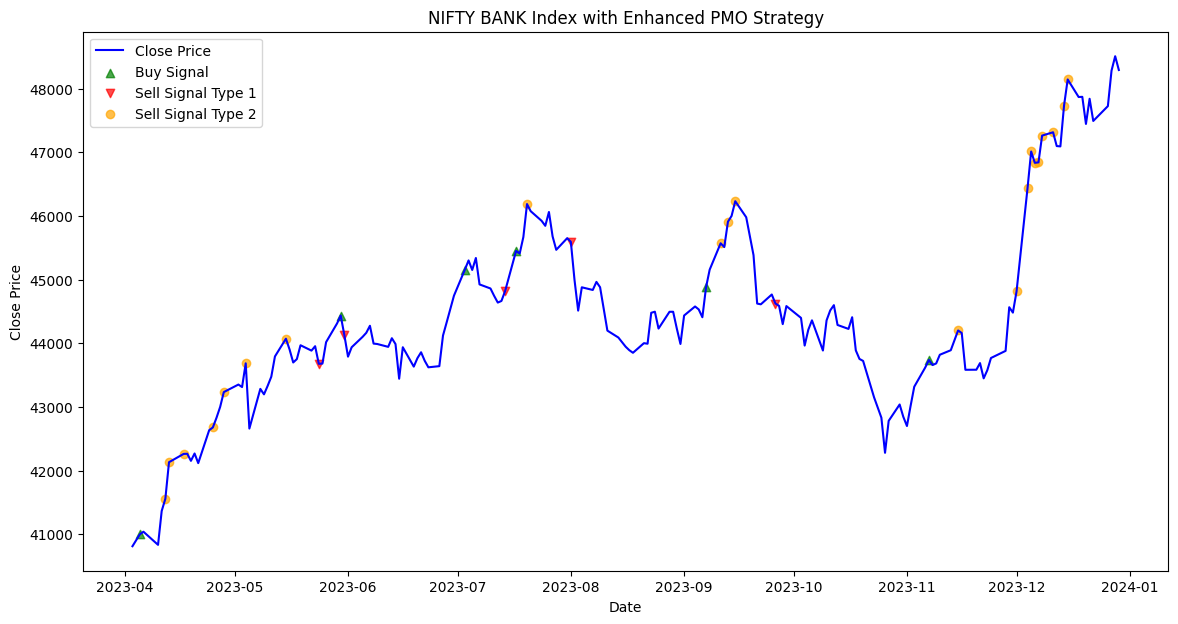

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical data for NIFTY BANK index
nifty_bank_data = yf.download('^NSEBANK', start='2023-04-01', end='2023-12-31')

# Calculate PMO
first_length = 35
second_length = 20
signal_length = 10

source = nifty_bank_data['Close']
roc = source.pct_change().fillna(0)

pmo = 10 * roc.ewm(span=first_length, adjust=False).mean().ewm(span=second_length, adjust=False).mean()
signal = pmo.ewm(span=signal_length, adjust=False).mean()

# Generate signals
buy_signal = (pmo > signal) & (pmo.shift(1) <= signal.shift(1))
sell_signal_type1 = (pmo < signal) & (pmo.shift(1) >= signal.shift(1))

nifty_bank_data['Buy_Signal'] = buy_signal
nifty_bank_data['Sell_Signal_Type1'] = sell_signal_type1
nifty_bank_data['Sell_Signal_Type2'] = False  # Initialize column for dynamic sell signal

# Initialize trading variables for simulation
capital = 1000000  # Starting capital
profit = 0  # Initialize profit
position = None  # Current position
gain_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]  # Define gain thresholds
current_threshold_index = 0  # Track current gain threshold
trades = []  # List to store trade details

for i in range(len(nifty_bank_data) - 1):  # Adjust loop to prevent out-of-range access
    current_price = nifty_bank_data['Close'].iloc[i]
    if nifty_bank_data['Buy_Signal'].iloc[i] and position is None:
        position = 'BUY'
        buy_price = current_price
        trades.append({'Type': 'BUY', 'Price': buy_price, 'Date': nifty_bank_data.index[i]})
        current_threshold_index = 0  # Reset for new buy
    elif position == 'BUY':
        percentage_increase = (current_price - buy_price) / buy_price
        # Check if current gain exceeds the current threshold
        if percentage_increase >= gain_thresholds[current_threshold_index]:
            # Update sell signal to True for visualization
            nifty_bank_data.at[nifty_bank_data.index[i], 'Sell_Signal_Type2'] = True
            # Move to next threshold if possible
            if current_threshold_index < len(gain_thresholds) - 1:
                current_threshold_index += 1
            else:
                # Sell if at last threshold and condition met
                position = None
                trades.append({'Type': 'SELL', 'Price': current_price, 'Date': nifty_bank_data.index[i], 'Reason': f"{gain_thresholds[current_threshold_index]*100}% Gain Achieved"})
                profit += (current_price - buy_price) * (capital * 0.02) / (buy_price * 0.02)
                current_threshold_index = 0  # Reset for next cycle
        elif sell_signal_type1.iloc[i]:
            # Additional condition to sell based on Type 1 signal
            position = None
            trades.append({'Type': 'SELL', 'Price': current_price, 'Date': nifty_bank_data.index[i], 'Reason': 'Type1 Sell','Stop Loss':gain_thresholds[current_threshold_index]})
            profit += (current_price - buy_price) * (capital * 0.02) / (buy_price * 0.02)

final_amount = capital + profit

# Output results
print(f"Final Capital: {final_amount}")
print(f"Total Profit: {profit}")
print("Trades Executed:")
for trade in trades:
    print(trade)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(nifty_bank_data['Close'], label='Close Price', color='blue')
plt.scatter(nifty_bank_data.index[nifty_bank_data['Buy_Signal']], nifty_bank_data['Close'][nifty_bank_data['Buy_Signal']], marker='^', color='green', label='Buy Signal', alpha=0.7)
plt.scatter(nifty_bank_data.index[nifty_bank_data['Sell_Signal_Type1']], nifty_bank_data['Close'][nifty_bank_data['Sell_Signal_Type1']], marker='v', color='red', label='Sell Signal Type 1', alpha=0.7)
plt.scatter(nifty_bank_data.index[nifty_bank_data['Sell_Signal_Type2']], nifty_bank_data['Close'][nifty_bank_data['Sell_Signal_Type2']], marker='o', color='orange', label='Sell Signal Type 2', alpha=0.7)
plt.title('NIFTY BANK Index with Enhanced PMO Strategy')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
